In [1]:
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os

2024-08-13 15:16:01.037615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 15:16:01.037756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 15:16:01.172005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Dataset

In [2]:
batch_size = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width)
img_shape = img_size + (3,)

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "/kaggle/input/chest-x-ray/train"
val_path = "/kaggle/input/chest-x-ray/val"

train_ds = image_dataset_from_directory(train_path,
                                    seed = 123,
                                    image_size = img_size,
                                    batch_size = batch_size)

val_ds = image_dataset_from_directory(val_path,
                                    seed = 123,
                                    image_size = img_size,
                                    batch_size = batch_size)



Found 5216 files belonging to 3 classes.
Found 640 files belonging to 3 classes.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['BACTERIAL PNEUMONIA', 'NORMAL', 'VIRAL PNEUMONIA']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 2)
validation_dataset = val_ds.skip(val_batches // 2)

# Buffered prefetching
train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [6]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

163
20
10


# Preprocess

In [7]:
for images in train_dataset.take(1):
    img = images[0]
    print(img.shape)  
    print(img.dtype)  
    print(np.min(img),np.max(img))  

(32, 224, 224, 3)
<dtype: 'float32'>
0.0 255.0


In [8]:
def normalize_images(image, label):
    # Normalize the image by dividing by 255.0
    image = image / 255.0
    return image, label

In [9]:
train_dataset = train_dataset.map(normalize_images)
validation_dataset = validation_dataset.map(normalize_images)
test_dataset = test_dataset.map(normalize_images)

In [10]:
for images in train_dataset.take(1):
    img = images[0]
    print(img.shape)  
    print(img.dtype)  
    print(np.min(img),np.max(img))  

(32, 224, 224, 3)
<dtype: 'float32'>
0.0 1.0


# Model building

## From scratch

In [35]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=img_shape),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile model
lr = 0.0001
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

# Display model architecture
cnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_125 (Conv2D)             │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 108, 108, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 106, 106, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 51, 51, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 49, 49, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,794,019 (18.29 MB)

 Trainable params: 4,794,019 (18.29 MB)

 Non-trainable params: 0 (0.00 B)

## Transfer learning

- Resnet50

In [39]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
pre_trained_model = ResNet50(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

# pre_trained_model.trainable = False

- VGG16

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

pre_trained_model = VGG16(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


- InceptionV3

In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

pre_trained_model = InceptionV3(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
pre_trained_model.summary()

## Fine-tuning

In [37]:
print("Number of layers: ", len(pre_trained_model.layers))

Number of layers:  175


ResNet50 & VGG16

In [40]:
# Freeze layers before conv4 and conv5 block
for layer in pre_trained_model.layers:
    if "conv5_block" in layer.name or "conv4_block" in layer.name:
        layer.trainable = True  # Unfreeze the last blocks
    else:
        layer.trainable = False  # Freeze all other layers

InceptionV3

In [22]:
for layer in pre_trained_model.layers:
    if "mixed7" in layer.name or "mixed8" in layer.name or "mixed9" in layer.name:
        layer.trainable = True  # Unfreeze the selected layers
    else:
        layer.trainable = False  # Freeze all other layers

## Add classification layer

In [41]:
global_average = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

inputs = tf.keras.Input(shape = img_shape)
x = preprocess_input(inputs)
x = pre_trained_model(x, training=False)
x = global_average(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

## Compile Model

In [42]:
# Compile model
LR = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ input_layer_18[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ input_layer_18[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ input_layer_18[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 2048)      │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 3)         │      6,147 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 22,090,755 (84.27 MB)

 Non-trainable params: 1,503,104 (5.73 MB)

# Model training

- From scratch

In [36]:
EPOCH = 15

history_cnn = cnn.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH)

Epoch 1/15
  1/163 ━━━━━━━━━━━━━━━━━━━━ 1:33:34 35s/step - accuracy: 0.3750 - loss: 1.0935

W0000 00:00:1723564781.694940      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5487 - loss: 0.9626

W0000 00:00:1723564804.750250      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 149ms/step - accuracy: 0.5491 - loss: 0.9618 - val_accuracy: 0.6313 - val_loss: 0.8844
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.7272 - loss: 0.6227 - val_accuracy: 0.6297 - val_loss: 0.9386
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.7547 - loss: 0.5627 - val_accuracy: 0.7344 - val_loss: 0.7536
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.7745 - loss: 0.5153 - val_accuracy: 0.7172 - val_loss: 0.7603
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.7813 - loss: 0.4938 - val_accuracy: 0.6875 - val_loss: 0.8547
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.7858 - loss: 0.4733 - val_accuracy: 0.6766 - val_loss: 0.9121
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.7918 - loss: 0.4613 - val_accuracy: 0.7391 - val_loss: 0.7553
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.7981 - loss: 0.4486 - val

- ResNet50

In [43]:
EPOCH = 15

# with tf.device("GPU"):
history_resnet = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH)

Epoch 1/15
  1/163 ━━━━━━━━━━━━━━━━━━━━ 1:35:19 35s/step - accuracy: 0.2500 - loss: 1.7659

W0000 00:00:1723565573.930952      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6841 - loss: 0.7062

W0000 00:00:1723565605.166344      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 202ms/step - accuracy: 0.6844 - loss: 0.7056 - val_accuracy: 0.3922 - val_loss: 1.7624
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 185ms/step - accuracy: 0.7579 - loss: 0.5303 - val_accuracy: 0.5125 - val_loss: 2.3173
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 180ms/step - accuracy: 0.7778 - loss: 0.5049 - val_accuracy: 0.6297 - val_loss: 1.5275
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 179ms/step - accuracy: 0.7973 - loss: 0.4619 - val_accuracy: 0.6734 - val_loss: 0.9442
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.8110 - loss: 0.4309 - val_accuracy: 0.6156 - val_loss: 1.6375
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.8147 - loss: 0.4173 - val_accuracy: 0.5969 - val_loss: 2.0663
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.8333 - loss: 0.3848 - val_accuracy: 0.6516 - val_loss: 1.2952
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.8351 - loss: 0.3717 - val

- VGG16

In [20]:
EPOCH = 15

history_vgg = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH)

Epoch 1/15
  1/163 ━━━━━━━━━━━━━━━━━━━━ 1:30:12 33s/step - accuracy: 0.3750 - loss: 1.9185

W0000 00:00:1723563308.333858      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3175 - loss: 1.9014

W0000 00:00:1723563329.859504      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 148ms/step - accuracy: 0.3177 - loss: 1.9005 - val_accuracy: 0.3906 - val_loss: 1.3751
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.4013 - loss: 1.5053 - val_accuracy: 0.3906 - val_loss: 1.1698
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.4073 - loss: 1.2392 - val_accuracy: 0.3906 - val_loss: 1.1028
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.3993 - loss: 1.1515 - val_accuracy: 0.3906 - val_loss: 1.1025
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.4035 - loss: 1.1217 - val_accuracy: 0.3906 - val_loss: 1.1102
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.4296 - loss: 1.1049 - val_accuracy: 0.3906 - val_loss: 1.1143
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.4205 - loss: 1.1080 - val_accuracy: 0.3906 - val_loss: 1.1147
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.4404 - loss: 1.0989 - val

- InceptionV3 

In [25]:
EPOCH = 15

history_inception = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH)

Epoch 1/15
  2/163 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.5000 - loss: 1.0407   

W0000 00:00:1723563882.644340      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4778 - loss: 1.0405

W0000 00:00:1723563904.610164      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 143ms/step - accuracy: 0.4779 - loss: 1.0404 - val_accuracy: 0.3922 - val_loss: 1.0619
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5164 - loss: 0.9912 - val_accuracy: 0.4047 - val_loss: 1.0318
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.5578 - loss: 0.9420 - val_accuracy: 0.4578 - val_loss: 1.0001
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.5853 - loss: 0.9123 - val_accuracy: 0.4766 - val_loss: 0.9823
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.5972 - loss: 0.8918 - val_accuracy: 0.4938 - val_loss: 0.9680
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.6193 - loss: 0.8605 - val_accuracy: 0.5094 - val_loss: 0.9543
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.6208 - loss: 0.8455 - val_accuracy: 0.5109 - val_loss: 0.9473
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.6228 - loss: 0.8332 - val

# Training evaluation

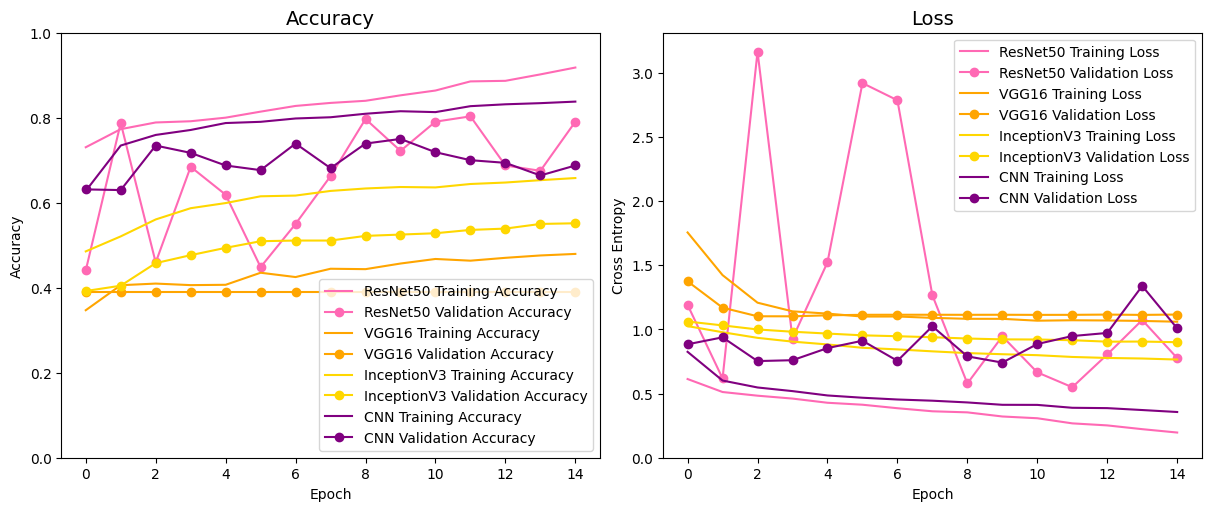

In [37]:
# training and validation accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), constrained_layout=True)

acc_resnet = history_resnet.history['accuracy']
val_acc_resnet = history_resnet.history['val_accuracy']

acc_vgg= history_vgg.history['accuracy']
val_acc_vgg = history_vgg.history['val_accuracy']

acc_inception = history_inception.history['accuracy']
val_acc_inception = history_inception.history['val_accuracy']

acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

ax[0].plot(acc_resnet, label='ResNet50 Training Accuracy', color='HotPink', )
ax[0].plot(val_acc_resnet, label='ResNet50 Validation Accuracy', color='HotPink', marker='o')

ax[0].plot(acc_vgg, label='VGG16 Training Accuracy', color='orange', )
ax[0].plot(val_acc_vgg, label='VGG16 Validation Accuracy', color='orange', marker='o')

ax[0].plot(acc_inception, label='InceptionV3 Training Accuracy', color='gold', )
ax[0].plot(val_acc_inception, label='InceptionV3 Validation Accuracy', color='gold', marker='o')

ax[0].plot(acc_cnn, label='CNN Training Accuracy', color='purple', )
ax[0].plot(val_acc_cnn, label='CNN Validation Accuracy', color='purple', marker='o')

ax[0].legend(loc='lower right')
ax[0].set(xlabel='Epoch', ylabel='Accuracy', ylim=[min(plt.ylim()),1])
ax[0].set_title('Accuracy', size=14)

# training and validation loss
loss_resnet = history_resnet.history['loss']
val_loss_resnet = history_resnet.history['val_loss']

loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']

loss_inception = history_inception.history['loss']
val_loss_inception = history_inception.history['val_loss']

loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']

ax[1].plot(loss_resnet, label='ResNet50 Training Loss', color='HotPink', )
ax[1].plot(val_loss_resnet, label='ResNet50 Validation Loss', color='HotPink', marker='o')

ax[1].plot(loss_vgg, label='VGG16 Training Loss', color='orange', )
ax[1].plot(val_loss_vgg, label='VGG16 Validation Loss', color='orange', marker='o')

ax[1].plot(loss_inception, label='InceptionV3 Training Loss', color='gold', )
ax[1].plot(val_loss_inception, label='InceptionV3 Validation Loss', color='gold', marker='o')

ax[1].plot(loss_cnn, label='CNN Training Loss', color='purple', )
ax[1].plot(val_loss_cnn, label='CNN Validation Loss', color='purple', marker='o')

ax[1].legend(loc='upper right')
ax[1].set(xlabel='Epoch', ylabel='Cross Entropy', ylim=[0,max(plt.ylim())])
ax[1].set_title('Loss', size=14)

plt.show()

# Testing

In [38]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [44]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.7342 - loss: 0.7614


{'loss': 0.7303587198257446, 'compile_metrics': 0.7562500238418579}

W0000 00:00:1723566108.702509      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


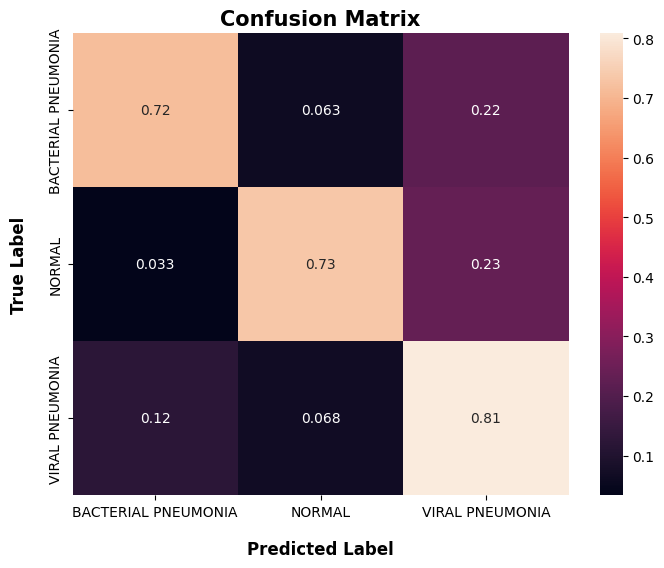

In [45]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.show()